We first found the Titanic dataset and found it pretty interesting, but a bit unoriginal. We then explored the kaggle competions further and found this spin on the classic dataset. We deemed this Spaceship Titanic would give us a fair challenge on our machine learning abilities, while not being too difficult.

This dataset is purely fictional and doesn't provide much in terms of usability. Still, we believed that picking a task that is fun to work with, will produce the best results.

# 1. Setup

In [9]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [21]:
# Saving train and test set to dataframe
train = pd.read_csv(r"DATA\train.csv")
test = pd.read_csv(r"DATA\test.csv")

In [33]:
# Train preview
print("Train shape:", train.shape)
train.head()

Train shape: (8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [32]:
# Test preview
print("Test shape:", test.shape)
test.head()

Test shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


## Feature explanation
- >PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- >HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- >CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- >Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
- >Age - The age of the passenger.
- >VIP - Whether the passenger has paid for special VIP service during the voyage.
- >RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- >Name - The first and last names of the passenger.
- >Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

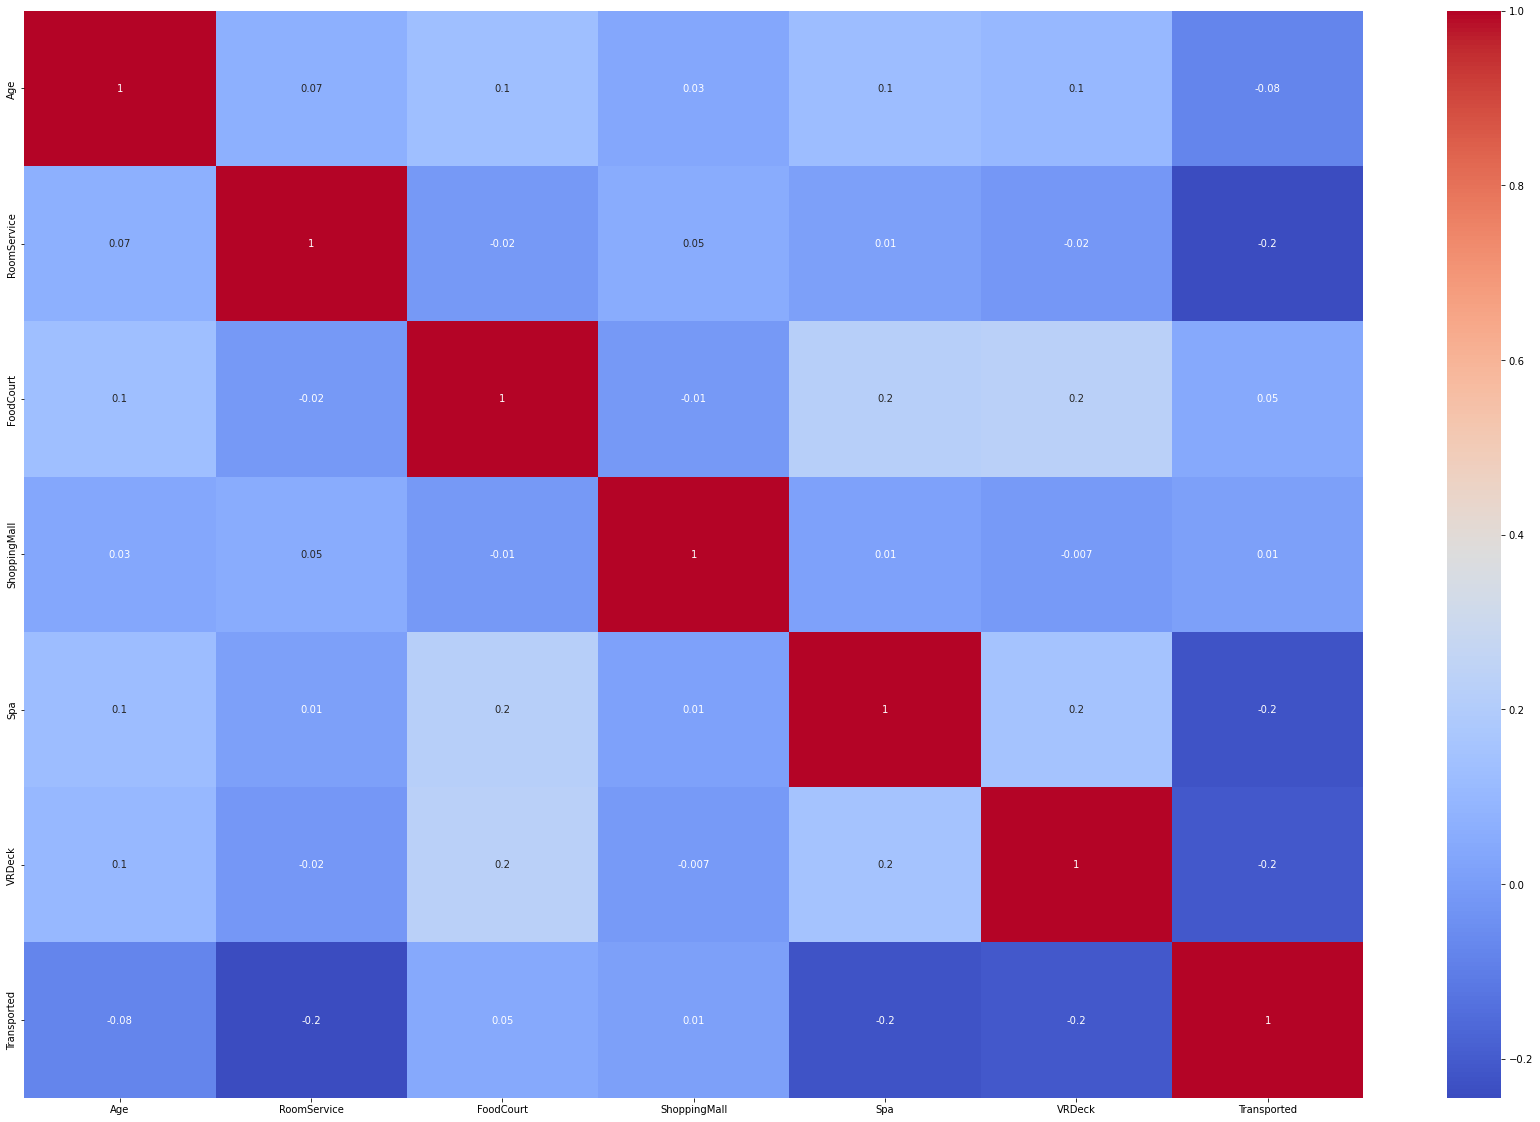

In [18]:
plt.figure(figsize=(30,20))
corrMatrix = train.corr()
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm', fmt='.1g')
plt.show()

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'RoomService'}>],
       [<AxesSubplot:title={'center':'FoodCourt'}>,
        <AxesSubplot:title={'center':'ShoppingMall'}>],
       [<AxesSubplot:title={'center':'Spa'}>,
        <AxesSubplot:title={'center':'VRDeck'}>]], dtype=object)

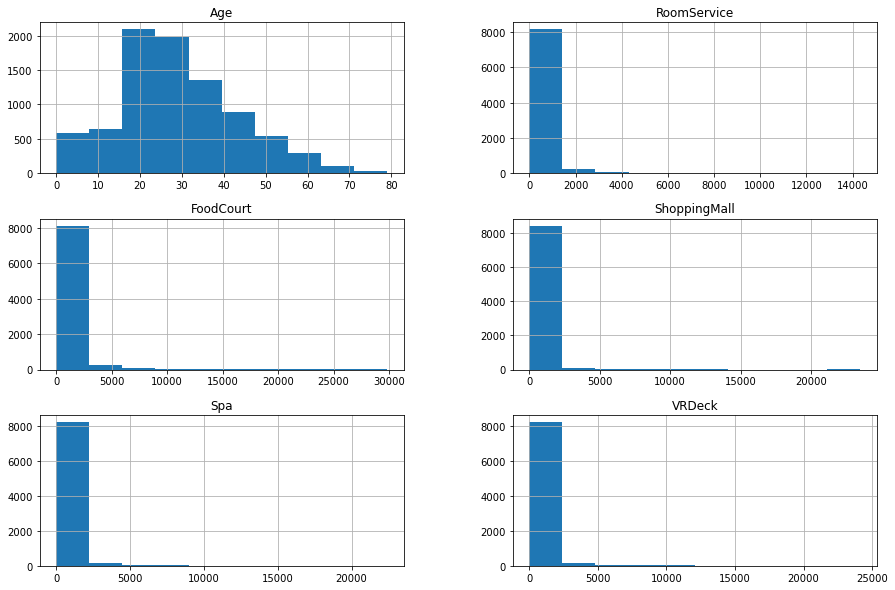

In [20]:
train.hist(bins=10, figsize=(15,10))

In [1]:
dskods

NameError: name 'dskods' is not defined